# <center>`STS-TCIA`</center>

##### <center>This notebook contains all steps required to proceed with a new image database and classify new possibilities for lung metastasis development. </center>


- Here we're importing some modules we'll work with, and also the `featureextractor` submodule from `radiomics`.

In [1]:
import os
import logging
import radiomics
from radiomics import featureextractor
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

gen_new_temp_STS_TCIA = False


## <center>`Part 1`</center>

- We're setting the `featureextractor` to receive the `sts-settings1.yaml` customized file, instad of the default `.yaml` file. The `sts-settings1.yaml` must also be configured to normalize the image data before the `extractor` generates the features.

In [2]:
radiomics.setVerbosity(logging.ERROR)

paramFile = "sts-settings1.yaml"
paramPath = os.path.join("..", "data", "radiomics", paramFile)
print("Parameter file:", paramPath)

# Instantiate the extractor
extractor = featureextractor.RadiomicsFeatureExtractor(paramPath)

print("Extraction parameters:\n\t", extractor.settings)
print("Enabled filters:\n\t", extractor.enabledImagetypes)
print("Enabled features:\n\t", extractor.enabledFeatures)


Parameter file: ../data/radiomics/sts-settings1.yaml
Extraction parameters:
	 {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': True, 'normalizeScale': 100, 'removeOutliers': None, 'resampledPixelSpacing': [3, 3, 3], 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True, 'voxelArrayShift': 300, 'binWidth': 10}
Enabled filters:
	 {'Original': {}, 'LoG': {'sigma': [3.0, 5.0]}, 'Wavelet': {}}
Enabled features:
	 {'shape': None, 'firstorder': None, 'glcm': None, 'glrlm': None, 'glszm': None, 'gldm': None, 'ngtdm': None}


- The variable `data_root` is set to be the path to `STS` data folder.


In [3]:
data_root = os.path.join('../data/STS')


- We build the `walk_files` dataframe containing the correspoding path to `label` and `image` `.nrrd` files for each patient image `T1` and `STIR` or `T2FS`.

In [4]:
walk_files = pd.DataFrame(
    columns=["provider", "patient", "image_type", "walk_LABEL", "walk_IMAGE"])


labelSuffix = '-label'
filesExtension = '.nrrd'


for provider in os.listdir(data_root):
    walk_provider = os.path.join(data_root, provider)
    if os.path.isdir(walk_provider) and os.listdir(walk_provider):
        for patient in os.listdir(walk_provider):
            walk_patient = os.path.join(walk_provider, patient)
            if os.path.isdir(walk_patient) and os.listdir(walk_patient):
                for image_type in os.listdir(walk_patient):
                    walk_image_type = os.path.join(walk_patient, image_type)
                    if os.path.isdir(walk_image_type) and os.listdir(walk_image_type):
                        for file in os.listdir(walk_image_type):
                            if not os.path.isdir(file):
                                walk_file = os.path.join(walk_image_type, file)
                                if file.endswith(labelSuffix + filesExtension):
                                    walk_LABEL_file = walk_file
                                elif file.endswith(filesExtension):
                                    walk_IMAGE_file = walk_file
                        walk_files.loc[len(walk_files)] = [
                            provider, patient, image_type, walk_LABEL_file, walk_IMAGE_file]


walk_files


,provider,patient,image_type,walk_LABEL,walk_IMAGE
0,TCIA,STS_037,T1,../data/STS/TCIA/STS_037/T1/1 RTSTRUCT RTstruc...,../data/STS/TCIA/STS_037/T1/3 AX TSE T1.nrrd
1,TCIA,STS_037,STIR,../data/STS/TCIA/STS_037/STIR/1 RTSTRUCT RTstr...,../data/STS/TCIA/STS_037/STIR/4 AX STIR.nrrd
2,TCIA,STS_047,T2FS,../data/STS/TCIA/STS_047/T2FS/1 RTSTRUCT RTstr...,../data/STS/TCIA/STS_047/T2FS/501 KNEE A...
3,TCIA,STS_047,T1,../data/STS/TCIA/STS_047/T1/1 RTSTRUCT RTstruc...,../data/STS/TCIA/STS_047/T1/601 KNEE AX ...
4,TCIA,STS_029,T1,../data/STS/TCIA/STS_029/T1/1 RTSTRUCT RTstruc...,../data/STS/TCIA/STS_029/T1/7 Axial T1 LT THI...
...,...,...,...,...,...
97,TCIA,STS_033,T1,../data/STS/TCIA/STS_033/T1/1 RTSTRUCT RTstruc...,../data/STS/TCIA/STS_033/T1/8 Axial FSET1 - RE...
98,TCIA,STS_020,T1,../data/STS/TCIA/STS_020/T1/1 RTSTRUCT RTstruc...,../data/STS/TCIA/STS_020/T1/3 Coronal FSET1.nrrd
99,TCIA,STS_020,STIR,../data/STS/TCIA/STS_020/STIR/1 RTSTRUCT RTstr...,../data/STS/TCIA/STS_020/STIR/4 Coronal Fast S...
100,TCIA,STS_051,T2FS,../data/STS/TCIA/STS_051/T2FS/1 RTSTRUCT RTstr...,../data/STS/TCIA/STS_051/T2FS/6 AXIAL FSE T2 ...


- Upon the `walk_files` dataframe, we could execute the feature `extractor`, which receives each image-label pair to build and evaluate the features for each `case_ID`. We stored all data in the `df_sts_tcia_rad` dataframe for each patient's `case_ID` (51*2=102 cases in total), which contains ***ALL the generated features*** in the columns.

In [5]:
if gen_new_temp_STS_TCIA:
    df_sts_tcia_rad = pd.DataFrame()
    df_sts_tcia_rad["case_ID"] = walk_files.provider + \
        "-"+walk_files.patient+"-"+walk_files.image_type
    df_sts_tcia_rad["case_ProviderID"] = walk_files.provider
    df_sts_tcia_rad["case_PatientID"] = walk_files.patient
    df_sts_tcia_rad["case_ImageType"] = walk_files.image_type

    df_sts_tcia_rad.set_index("case_ID", inplace=True)
    for index, label_path, image_path in zip(df_sts_tcia_rad.index, walk_files.walk_LABEL, walk_files.walk_IMAGE):
        radiomics = extractor.execute(image_path, label_path)
        for rad_key, rad_val in radiomics.items():
            if isinstance(rad_val, dict):
                df_sts_tcia_rad.loc[index, rad_key] = json.dumps(rad_val)
            elif isinstance(rad_val, tuple):
                df_sts_tcia_rad.loc[index, rad_key] = str(rad_val)
            else:
                df_sts_tcia_rad.loc[index, rad_key] = rad_val


- Temporary .csv conversion just to save the runned `df_sts_tcia_rad` dataframe (~5min running)

In [6]:
if gen_new_temp_STS_TCIA:
    file_name = "Temp_STS-TCIA.csv"
    df_sts_tcia_rad.to_csv(file_name)


- Now, we start by opening the `temporary file`

In [7]:
file_name = "Temp_STS-TCIA.csv"
df_sts_tcia_rad = pd.read_csv(file_name)
df_sts_tcia_rad = df_sts_tcia_rad.sort_values(
    ["case_PatientID", "case_ImageType"])
df_sts_tcia_rad.drop(columns=['case_ID'], inplace=True)
df_sts_tcia_rad.head(5)


,case_ProviderID,case_PatientID,case_ImageType,diagnostics_Versions_PyRadiomics,diagnostics_Versions_Numpy,diagnostics_Versions_SimpleITK,diagnostics_Versions_PyWavelet,diagnostics_Versions_Python,diagnostics_Configuration_Settings,diagnostics_Configuration_EnabledImageTypes,...,wavelet-LLL_gldm_LargeDependenceLowGrayLevelEmphasis,wavelet-LLL_gldm_LowGrayLevelEmphasis,wavelet-LLL_gldm_SmallDependenceEmphasis,wavelet-LLL_gldm_SmallDependenceHighGrayLevelEmphasis,wavelet-LLL_gldm_SmallDependenceLowGrayLevelEmphasis,wavelet-LLL_ngtdm_Busyness,wavelet-LLL_ngtdm_Coarseness,wavelet-LLL_ngtdm_Complexity,wavelet-LLL_ngtdm_Contrast,wavelet-LLL_ngtdm_Strength
11,TCIA,STS_001,T1,v3.0.1,1.21.5,2.1.1.2,1.3.0,3.10.4,"{""minimumROIDimensions"": 2, ""minimumROISize"": ...","{""Original"": {}, ""LoG"": {""sigma"": [3.0, 5.0]},...",...,0.382355,0.014371,0.111562,13.895895,0.002196,4.370039,0.000824,301.427279,0.046065,0.190421
10,TCIA,STS_001,T2FS,v3.0.1,1.21.5,2.1.1.2,1.3.0,3.10.4,"{""minimumROIDimensions"": 2, ""minimumROISize"": ...","{""Original"": {}, ""LoG"": {""sigma"": [3.0, 5.0]},...",...,0.000783,0.000306,0.623462,4077.229667,0.000234,0.098624,0.000907,54522.134897,0.365681,5.735231
69,TCIA,STS_002,STIR,v3.0.1,1.21.5,2.1.1.2,1.3.0,3.10.4,"{""minimumROIDimensions"": 2, ""minimumROISize"": ...","{""Original"": {}, ""LoG"": {""sigma"": [3.0, 5.0]},...",...,0.005826,0.001565,0.713815,7702.367375,0.000616,0.006910,0.009653,213222.857334,0.815927,261.107140
68,TCIA,STS_002,T1,v3.0.1,1.21.5,2.1.1.2,1.3.0,3.10.4,"{""minimumROIDimensions"": 2, ""minimumROISize"": ...","{""Original"": {}, ""LoG"": {""sigma"": [3.0, 5.0]},...",...,0.184798,0.007644,0.283175,256.102692,0.002118,0.111926,0.008068,4598.211806,0.165676,15.788664
57,TCIA,STS_003,STIR,v3.0.1,1.21.5,2.1.1.2,1.3.0,3.10.4,"{""minimumROIDimensions"": 2, ""minimumROISize"": ...","{""Original"": {}, ""LoG"": {""sigma"": [3.0, 5.0]},...",...,0.001594,0.001085,0.665096,5362.708021,0.000985,0.014839,0.004550,77016.824576,0.534899,35.008041


In [8]:
def remove_cols(DataFrame, string):
    """Remover colunas com uma string no nome

    Args:
        DataFrame (DataFrame): Dataframe que sera removido
        string (str): texto para buscar colunas para remover

    Returns:
        DataFrame: Dataframe sem colunas desejadas
    """
    list_cols = list(
        col for col in DataFrame.columns if col.startswith(string))
    return DataFrame.drop(list_cols, axis=1)


def tag_cols(data, prefix, excepts):
    """Adicionar tag nas colunas

    Args:
        data (DataFrame): DataFrame que sera colocado tag
        prefix (str): tag que será adicionada
        excepts (str): Colunas que não terão tags

    Returns:
        _type_: _description_
    """
    data.columns = [col if col.startswith(
        excepts) else prefix+"_"+col for col in data.columns]
    return data


In [9]:
data = remove_cols(df_sts_tcia_rad, "diagnostics_")

data_t1 = data.loc[data.case_ImageType == "T1"]
tag_cols(data_t1, "T1", "case_")
data_t1 = data_t1.drop(columns=["case_ImageType"])

data_fs = data.loc[data.case_ImageType != 'T1']
tag_cols(data_fs, "FS", "case_")
data_fs = data_fs.drop(columns=['case_ProviderID', 'case_ImageType'])


In [10]:
df_sts_tcia_rad_merged = pd.merge(
    data_t1, data_fs, left_on='case_PatientID', right_on='case_PatientID')

df_sts_tcia_rad_merged.head(5)


,case_ProviderID,case_PatientID,T1_original_shape_Elongation,T1_original_shape_Flatness,T1_original_shape_LeastAxisLength,T1_original_shape_MajorAxisLength,T1_original_shape_Maximum2DDiameterColumn,T1_original_shape_Maximum2DDiameterRow,T1_original_shape_Maximum2DDiameterSlice,T1_original_shape_Maximum3DDiameter,...,FS_wavelet-LLL_gldm_LargeDependenceLowGrayLevelEmphasis,FS_wavelet-LLL_gldm_LowGrayLevelEmphasis,FS_wavelet-LLL_gldm_SmallDependenceEmphasis,FS_wavelet-LLL_gldm_SmallDependenceHighGrayLevelEmphasis,FS_wavelet-LLL_gldm_SmallDependenceLowGrayLevelEmphasis,FS_wavelet-LLL_ngtdm_Busyness,FS_wavelet-LLL_ngtdm_Coarseness,FS_wavelet-LLL_ngtdm_Complexity,FS_wavelet-LLL_ngtdm_Contrast,FS_wavelet-LLL_ngtdm_Strength
0,TCIA,STS_001,0.767756,0.643837,65.059651,101.049858,116.730459,111.000000,93.962759,118.224363,...,0.000783,0.000306,0.623462,4077.229667,0.000234,0.098624,0.000907,54522.134897,0.365681,5.735231
1,TCIA,STS_002,0.895324,0.672732,33.881630,50.364231,58.249464,54.083269,58.249464,58.557664,...,0.005826,0.001565,0.713815,7702.367375,0.000616,0.006910,0.009653,213222.857334,0.815927,261.107140
2,TCIA,STS_003,0.701973,0.685473,42.574564,62.109765,65.520989,72.622311,55.072679,76.249590,...,0.001594,0.001085,0.665096,5362.708021,0.000985,0.014839,0.004550,77016.824576,0.534899,35.008041
3,TCIA,STS_004,0.545471,0.447141,53.787869,120.292849,158.858428,141.509717,77.129761,159.113167,...,0.005801,0.001067,0.621071,4436.085618,0.000608,0.061644,0.001189,282803.977945,0.784436,57.831025
4,TCIA,STS_005,0.601763,0.490816,69.224991,141.040479,166.628329,162.996932,98.407317,169.307413,...,0.005537,0.000692,0.369232,1207.975509,0.000323,0.128208,0.001052,23271.080451,0.147270,6.696299


- Finally, we exported the `df_sts_tcia_rad_merged` dataframe to a `.csv` file. Which means we've extracted all `radiomics` features from the `stored images` for each patient (sample),

In [11]:
file_name = "STS-TCIA" + ".csv"
df_sts_tcia_rad_merged.to_csv(file_name, index=False)


## <center>`Part 2`</center>

- We start by calling back the generated (and already merged) `STS-TCIA-Radiomics-sts-settings1.csv` as a dataframe.

In [12]:
file_name = "STS-TCIA-Radiomics-" + paramFile[:-5] + ".csv"

df_sts_tcia_rad = pd.read_csv(file_name).sort_values(
    ["case_PatientID"], ignore_index=True)
df_sts_tcia_rad.head(5)


,case_ProviderID,case_PatientID,T1_original_shape_Elongation,T1_original_shape_Flatness,T1_original_shape_LeastAxisLength,T1_original_shape_MajorAxisLength,T1_original_shape_Maximum2DDiameterColumn,T1_original_shape_Maximum2DDiameterRow,T1_original_shape_Maximum2DDiameterSlice,T1_original_shape_Maximum3DDiameter,...,FS_wavelet-LLL_gldm_LargeDependenceLowGrayLevelEmphasis,FS_wavelet-LLL_gldm_LowGrayLevelEmphasis,FS_wavelet-LLL_gldm_SmallDependenceEmphasis,FS_wavelet-LLL_gldm_SmallDependenceHighGrayLevelEmphasis,FS_wavelet-LLL_gldm_SmallDependenceLowGrayLevelEmphasis,FS_wavelet-LLL_ngtdm_Busyness,FS_wavelet-LLL_ngtdm_Coarseness,FS_wavelet-LLL_ngtdm_Complexity,FS_wavelet-LLL_ngtdm_Contrast,FS_wavelet-LLL_ngtdm_Strength
0,TCIA,STS_001,0.767756,0.643837,65.059651,101.049858,116.730459,111.000000,93.962759,118.224363,...,0.000783,0.000306,0.623462,4077.229667,0.000234,0.098624,0.000907,54522.134897,0.365681,5.735231
1,TCIA,STS_002,0.895324,0.672732,33.881630,50.364231,58.249464,54.083269,58.249464,58.557664,...,0.005826,0.001565,0.713815,7702.367375,0.000616,0.006910,0.009653,213222.857334,0.815927,261.107140
2,TCIA,STS_003,0.701973,0.685473,42.574564,62.109765,65.520989,72.622311,55.072679,76.249590,...,0.001594,0.001085,0.665096,5362.708021,0.000985,0.014839,0.004550,77016.824576,0.534899,35.008041
3,TCIA,STS_004,0.545471,0.447141,53.787869,120.292849,158.858428,141.509717,77.129761,159.113167,...,0.005801,0.001067,0.621071,4436.085618,0.000608,0.061644,0.001189,282803.977945,0.784436,57.831025
4,TCIA,STS_005,0.601763,0.490816,69.224991,141.040479,166.628329,162.996932,98.407317,169.307413,...,0.005537,0.000692,0.369232,1207.975509,0.000323,0.128208,0.001052,23271.080451,0.147270,6.696299


- Here we also bring the Clinical data from each patient, whitch contains the `target variable` in the last column (if the patient did develop lung methastasis), which is `LungMets` (0 for no, 1 for yes). That's the only column we're interested by now. 

In [13]:
df_sts_tcia_cli = pd.read_csv(os.path.join(
    "../data/STS/STS-TCIA-Clinical.csv"), sep=";")
df_sts_tcia_cli.head(5)


,PatientID,Age,Sex,Histological type,MSKCC type,Site of primary STS,Grade,Time - diagnosis to MRI scan (days),Time - MRI scan to PET scan (days),Treatment,"Outcome (recurrence, mets)",Time - diagnosis to outcome (days),"Status (NED, AWD, D)",Time - diagnosis to last follow-up (days),LungMets
0,STS_001,59,Male,pleiomorphic liposarcoma,Liposarcoma,left thigh,High,-7,4,Radiotherapy + Surgery + Chemotherapy,Mets – arms,266,D,845,0
1,STS_002,61,Male,pleiomorphic leiomyosarcoma,Leiomyosarcoma,left buttock,High,-10,25,Radiotherapy + Surgery,--,--,NED,501,0
2,STS_003,17,Female,epithelioid sarcoma,Other,right buttock,Intermediate,-13,15,Radiotherapy + Surgery,--,--,NED,756,0
3,STS_004,22,Female,malignant fibrous histiocytoma,MFH,right thigh,Low,-6,22,Radiotherapy + Surgery,--,--,NED,1792,0
4,STS_005,83,Female,pleiomorphic leiomyosarcoma,Leiomyosarcoma,left biceps,High,-24,34,Radiotherapy + Surgery,--,--,NED,647,0


- Comparing a patient who developed pulmonary metastasis with which he did not develop.

In [14]:
# Contagem de frequência de 0 e 1
LungMets_count = df_sts_tcia_cli.LungMets.value_counts()

LungMets_count_normalize = df_sts_tcia_cli.LungMets.value_counts(
    normalize=True)  # Frequência relativa

LungMets_data = {"Metastasis": ("No", "Yes"), "Patients": LungMets_count,
                 "Proportions": LungMets_count_normalize}  # Agrupando dados para o dataframe

df_sts_tcia_cli_mets = pd.DataFrame(data=LungMets_data)  # Montando DataFrame
df_sts_tcia_cli_mets.style.hide_index()


/tmp/ipykernel_857/3350897204.py:11: FutureWarning: this method is deprecated in favour of `Styler.hide(axis='index')`
  df_sts_tcia_cli_mets.style.hide_index()


Metastasis,Patients,Proportions
No,32,0.627451
Yes,19,0.372549


<AxesSubplot:xlabel='Metastasis'>

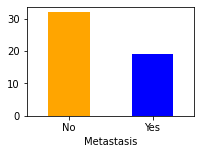

In [15]:
df_sts_tcia_cli_mets.plot.bar(x="Metastasis", y="Patients", rot=0, color=(
    "orange", "blue"), legend=None, figsize=(3, 2))


## <center>`Introducing FeatureSelector and Models`</center>

- Importing the `feature_selection` methods and `classification models` which will be implemented for testing purposes.

In [16]:
from sklearn.feature_selection import mutual_info_classif, GenericUnivariateSelect, RFECV, SelectFromModel, VarianceThreshold
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix

random_seed = np.random.randint(10000)


- X receives all features from the 51 patients except for `case_ProviderID` and `case_PatientID`. y is simply the `target` variable.

In [17]:
X = df_sts_tcia_rad.drop(["case_ProviderID", "case_PatientID"], axis=1)
y = np.array(df_sts_tcia_cli.LungMets)


- Defining `estimators`, `feature selection methods` and `classifiers` ___**respectively**___

In [18]:
estimator_RFE = SVC(kernel="linear", verbose=0, random_state=random_seed)
estimator_L1LSVC = LinearSVC(penalty="l2", dual=True, verbose=0, random_state=random_seed)
estimator_L1LR = LogisticRegression(
    penalty="l2", dual=True, solver="liblinear", verbose=0, random_state=random_seed)

MIC_sel = GenericUnivariateSelect(
    score_func=mutual_info_classif, mode='k_best', param=50)
RFE_sel = RFECV(estimator_RFE, min_features_to_select=50,
                step=10, cv=StratifiedKFold(5), scoring='accuracy')
L1LSVC_sel = SelectFromModel(estimator_L1LSVC)
L1LR_sel = SelectFromModel(estimator_L1LR)

rf_clf = RandomForestClassifier(
    n_estimators=20, bootstrap=True, min_samples_leaf=3, max_features="sqrt", random_state=random_seed)
lr_clf = LogisticRegression(C=1.0, class_weight="balanced", penalty="l2", random_state=random_seed)
knn_clf = KNeighborsClassifier(n_neighbors=5, p=2)
svc_clf = SVC(C=1, kernel="rbf", class_weight="balanced", probability=True, random_state=random_seed)


- Basic / self-explanatory functions so we can save some names and introduce some visualization

In [19]:
def get_name(model_or_selector):
    """Retira o nome do modelo ou seletor de features

    Args:
        model_or_selector (model_or_selector): função modelo ou função do seletor

    Returns:
        str: Só o nome do modelo ou seletor
    """
    full_name = str(model_or_selector)
    end_name = full_name.index("(")
    name = full_name[:end_name]
    return name


def get_name_estimator(selector):
    """Retorna o nome do estimador do seletor de feature se tiver, se não ele retorna None

    Args:
        model_or_selector (selector): função do seletor

    Returns:
        str: nome do estimator
    """
    if "estimator" in selector.get_params().keys():
        full_name = selector.get_params()["estimator"]
        return get_name(full_name)
    else:
        return None


def get_selector_and_estimator(selector):
    """Retorna  nome do tipo de seletor com o estimator separado com anderline

    Args:
        selector (selector): função do seletor

    Returns:
        str: nome do seletor mais estimator se tiver estimator
    """
    estimator_name = get_name_estimator(selector)
    selector_name = get_name(selector)
    if estimator_name is None:
        return selector_name
    else:
        return selector_name+"_"+estimator_name


- For each `Feature_selection method` we collect it's `fit_time` and also the final `shape` of ___**`relevant features`**___

In [20]:
from time import time
selectors = [MIC_sel, L1LSVC_sel, L1LR_sel]
models = [rf_clf, lr_clf, knn_clf, svc_clf]

selectors_infos = pd.DataFrame(
    columns="selector time shape features_list".split(" "))

all_features_name = X.columns.values.tolist()


for selector in selectors:
    
    tic = time()
    selector.fit(X, y)
    toc = time()
    shape_X = selector.transform(X).shape
    features_list = selector.get_feature_names_out(all_features_name)
    
    selectors_infos.loc[len(selectors_infos)] = [
        get_selector_and_estimator(selector), toc-tic, shape_X, features_list]

selectors_infos


/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


,selector,time,shape,features_list
0,GenericUnivariateSelect,4.166469,"(51, 50)","[T1_original_shape_MeshVolume, T1_original_sha..."
1,SelectFromModel_LinearSVC,0.764613,"(51, 46)","[T1_original_firstorder_Energy, T1_original_fi..."
2,SelectFromModel_LogisticRegression,0.071247,"(51, 51)","[T1_original_firstorder_Energy, T1_original_fi..."


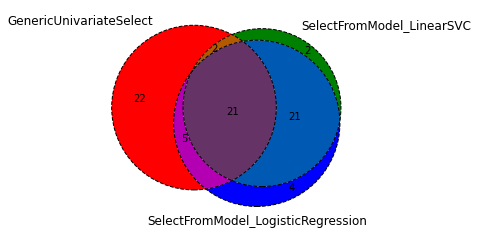

In [21]:
from matplotlib_venn import venn3, venn3_circles

venn_data = [set(x) for x in selectors_infos.features_list]
venn_label = selectors_infos.selector

venn3(venn_data, set_labels=venn_label, alpha=1)
venn3_circles(venn_data, linestyle='dashed', linewidth=1, )


- Building the results dataframe, which contains for each trained model, every singe used feature_selection method (so, different features (`X_new`) for each `fs_method`) with some training statistical data.

In [22]:
def sensitivity(TP, FN):
    return TP / (TP + FN)


def specificity(TN, FP):
    return TN / (TN + FP)


def accuracy(TN, FP, FN, TP):
    return (TP + TN) / (TN + FP + FN + TP)


def MCC(TN, FP, FN, TP):
    return (TP * TN - FP * FN) / np.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))


def confusion_matrix_scorer(clf, X, y):
    y_pred = clf.predict(X)
    cm = confusion_matrix(y, y_pred)
    TN, FP, FN, TP = cm[0, 0], cm[0, 1], cm[1, 0], cm[1, 1]

    return {"sensitivity": sensitivity(TP, FN), "specificity": specificity(TN, FP), "accuracy": accuracy(TN, FP, FN, TP), "MCC": MCC(TN, FP, FN, TP)}


In [23]:
columns_names = ["models", "selector", "sensitivity_mean", "specificity_mean", "accuracy_mean",
                 "MCC_mean", "fit_time_mean", "feature_list", "selector_params", "model_params"]
results = pd.DataFrame(columns=columns_names)


scoring = confusion_matrix_scorer

for selector in selectors:
    features_list = selector.get_feature_names_out(all_features_name)
    X_new = selector.transform(X)
    selector_name = get_selector_and_estimator(selector)
    selector_params = selector.get_params()
    for model in models:
        model_name = get_name(model)
        model_params = model.get_params()
        result = cross_validate(model, X_new, y, scoring=scoring, verbose=0)

        sensitivity_mean = result["test_sensitivity"].mean()
        specificity_mean = result["test_specificity"].mean()
        accuracy_mean = result["test_accuracy"].mean()
        MCC_mean = result["test_MCC"].mean()
        fit_mean = result["fit_time"].mean()

        results.loc[len(results)] = [model_name, selector_name, sensitivity_mean, specificity_mean, accuracy_mean,
                                     MCC_mean, fit_mean, features_list, selector_params, model_params]


/tmp/ipykernel_857/3349344532.py:14: RuntimeWarning: invalid value encountered in true_divide
  return (TP * TN - FP * FN) / np.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preproc

- Saving the results dataframe into a .csv file for future analysis

In [24]:
results.to_csv("Infos.csv")
results


,models,selector,sensitivity_mean,specificity_mean,accuracy_mean,MCC_mean,fit_time_mean,feature_list,selector_params,model_params
0,RandomForestClassifier,GenericUnivariateSelect,0.483333,0.776190,0.663636,NaN,0.034335,"[T1_original_shape_MeshVolume, T1_original_sha...","{'mode': 'k_best', 'param': 50, 'score_func': ...","{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w..."
1,LogisticRegression,GenericUnivariateSelect,0.516667,0.495238,0.509091,0.013801,0.041521,"[T1_original_shape_MeshVolume, T1_original_sha...","{'mode': 'k_best', 'param': 50, 'score_func': ...","{'C': 1.0, 'class_weight': 'balanced', 'dual':..."
2,KNeighborsClassifier,GenericUnivariateSelect,0.583333,0.714286,0.665455,0.308778,0.000419,"[T1_original_shape_MeshVolume, T1_original_sha...","{'mode': 'k_best', 'param': 50, 'score_func': ...","{'algorithm': 'auto', 'leaf_size': 30, 'metric..."
3,SVC,GenericUnivariateSelect,0.533333,0.690476,0.627273,0.228183,0.002095,"[T1_original_shape_MeshVolume, T1_original_sha...","{'mode': 'k_best', 'param': 50, 'score_func': ...","{'C': 1, 'break_ties': False, 'cache_size': 20..."
4,RandomForestClassifier,SelectFromModel_LinearSVC,0.433333,0.776190,0.643636,0.236816,0.037459,"[T1_original_firstorder_Energy, T1_original_fi...","{'estimator__C': 1.0, 'estimator__class_weight...","{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w..."
5,LogisticRegression,SelectFromModel_LinearSVC,0.366667,0.619048,0.527273,-0.010540,0.015815,"[T1_original_firstorder_Energy, T1_original_fi...","{'estimator__C': 1.0, 'estimator__class_weight...","{'C': 1.0, 'class_weight': 'balanced', 'dual':..."
6,KNeighborsClassifier,SelectFromModel_LinearSVC,0.433333,0.690476,0.587273,0.098734,0.000376,"[T1_original_firstorder_Energy, T1_original_fi...","{'estimator__C': 1.0, 'estimator__class_weight...","{'algorithm': 'auto', 'leaf_size': 30, 'metric..."
7,SVC,SelectFromModel_LinearSVC,0.533333,0.685714,0.623636,0.244601,0.002192,"[T1_original_firstorder_Energy, T1_original_fi...","{'estimator__C': 1.0, 'estimator__class_weight...","{'C': 1, 'break_ties': False, 'cache_size': 20..."
8,RandomForestClassifier,SelectFromModel_LogisticRegression,0.250000,0.809524,0.605455,0.092359,0.034588,"[T1_original_firstorder_Energy, T1_original_fi...","{'estimator__C': 1.0, 'estimator__class_weight...","{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w..."
9,LogisticRegression,SelectFromModel_LogisticRegression,0.466667,0.585714,0.547273,0.054065,0.016292,"[T1_original_firstorder_Energy, T1_original_fi...","{'estimator__C': 1.0, 'estimator__class_weight...","{'C': 1.0, 'class_weight': 'balanced', 'dual':..."


### Visualizing the data (training time average x F1_score), the shorter the better.

In [25]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set()
%matplotlib inline


In [26]:
hfont = {'fontname': 'DejaVu Sans'}
font_color = '#525252'
facecolor = '#eaeaf2'
colors = plt.colormaps["tab20c"](np.arange(len(selectors))*4)
title0 = 'Tempo médio de treino (ms)'
title1 = 'Média do specificity [0, 1]'
temp_index = results.models+"_"+results.selector
label_index = results.models

column0 = results.fit_time_mean * 1000
column1 = results.specificity_mean


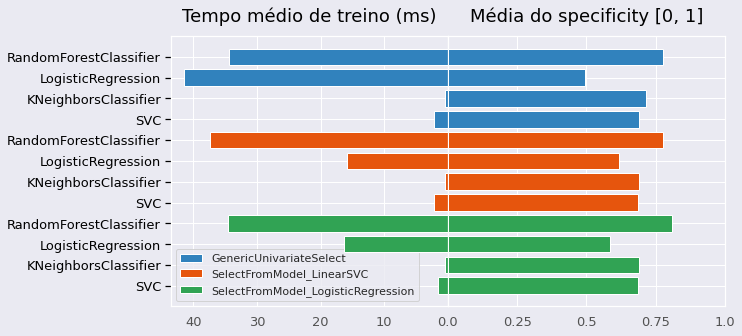

In [27]:
fig, axes = plt.subplots(
    figsize=(10, 5), facecolor=facecolor, ncols=2, sharey=True)
fig.tight_layout()


for (selector, color) in zip(selectors, colors):
    dados_selector = results.selector == get_selector_and_estimator(selector)
    new_column0 = column0.loc[dados_selector]
    new_column1 = column1.loc[dados_selector]
    new_index = temp_index.loc[dados_selector]
    axes[0].barh(new_index, new_column0,
                 align='center', color=color, zorder=10)
    axes[1].barh(new_index, new_column1,
                 align='center', color=color, zorder=10)

axes[0].legend(results.selector.unique(), loc="lower left")

axes[1].set_xticks(np.linspace(0, 1, num=5, endpoint=True))
axes[1].set_xticklabels(np.linspace(0, 1, num=5, endpoint=True))
axes[0].set_xticks(np.arange(10, 41, 10))

for label in (axes[0].get_xticklabels() + axes[0].get_yticklabels()):
    label.set(fontsize=13, color=font_color, **hfont)
for label in (axes[1].get_xticklabels() + axes[1].get_yticklabels()):
    label.set(fontsize=13, color=font_color, **hfont)
axes[0].set_title(title0, fontsize=18, pad=15, color="black", **hfont)
axes[1].set_title(title1, fontsize=18, pad=15, color="black", **hfont)
axes[0].set(yticks=temp_index, yticklabels=label_index)
axes[0].yaxis.tick_left()
axes[0].tick_params(axis='y', colors='black')  # tick color
# If you have positive numbers and want to invert the x-axis of the left plot
axes[0].invert_xaxis()

# To show data from highest to lowest
plt.gca().invert_yaxis()

plt.subplots_adjust(wspace=0, top=0.85, bottom=0.1, left=0.18, right=0.95)


In [28]:
import shap
from sklearn.model_selection import train_test_split
shap.initjs()


In [29]:
X_train, X_test, y_train, y_test = train_test_split(L1LR_sel.transform(X), y, test_size=0.2, random_state=random_seed)
rf_clf.fit(X_train, y_train)
cm = confusion_matrix(y_test, rf_clf.predict(X_test))
TN, FP, FN, TP = cm[0, 0], cm[0, 1], cm[1, 0], cm[1, 1]
specificity(TN, FP)


0.75

In [30]:
explainer = shap.TreeExplainer(rf_clf, feature_names=L1LR_sel.get_feature_names_out(all_features_name))
shap_values = explainer.shap_values(X_train)


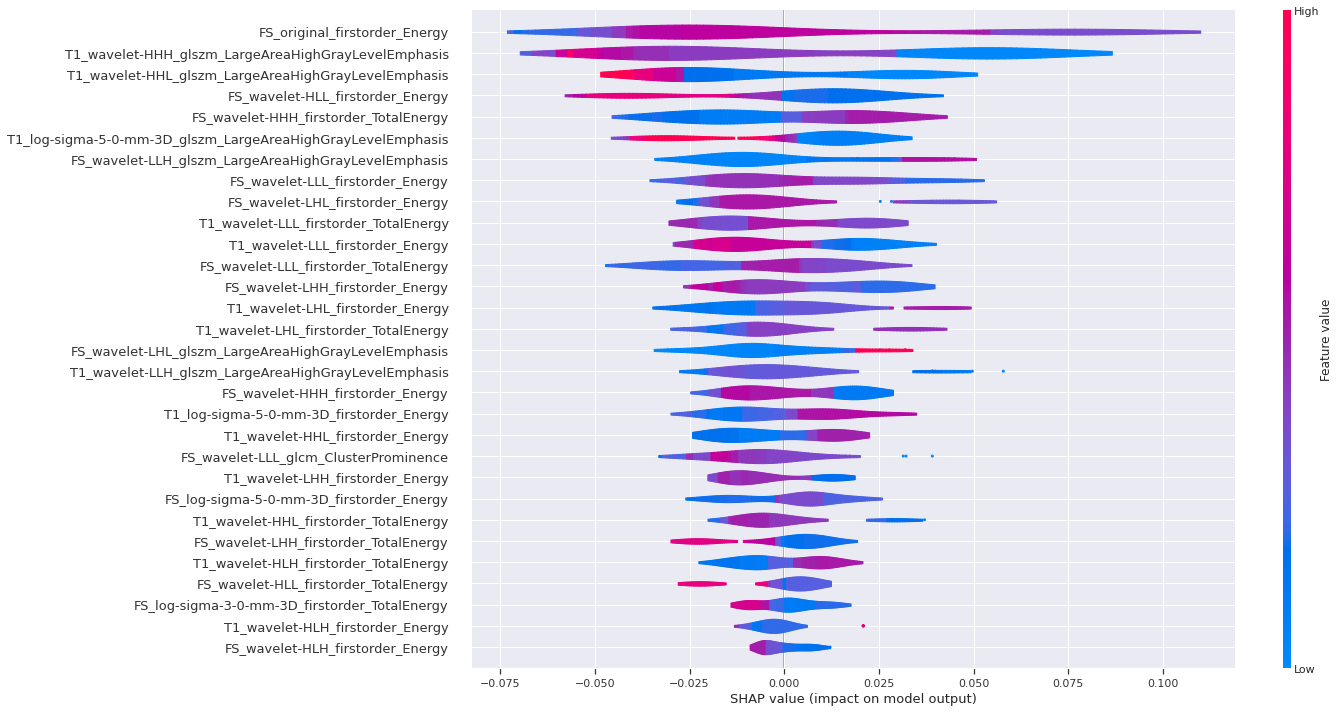

In [39]:
shap.summary_plot(shap_values[0], X_train, feature_names=explainer.feature_names, show=True, max_display=30, plot_type="violin", plot_size=(20,10), class_names=["No_mets", "Yes_mets"])


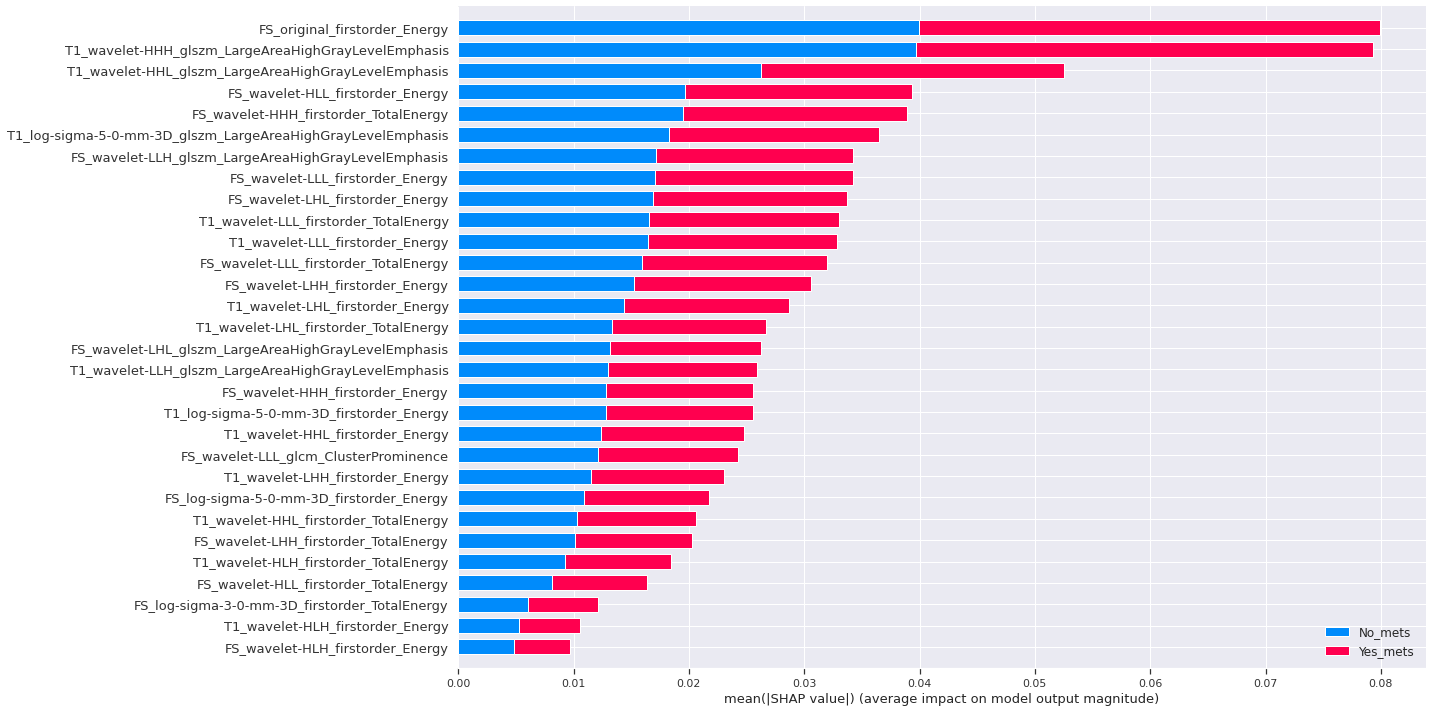

In [47]:
shap.summary_plot(shap_values, X_train, feature_names=explainer.feature_names, show=True, max_display=30, plot_type="bar", plot_size=(20,10), class_names=["No_mets", "Yes_mets"])


In [41]:
shap.decision_plot(explainer.expected_value[1], shap_values[1], feature_names=explainer.feature_names, show=True, link="identity", feature_order="importance")


ValueError: operands could not be broadcast together with shapes (2,) (40,21) 

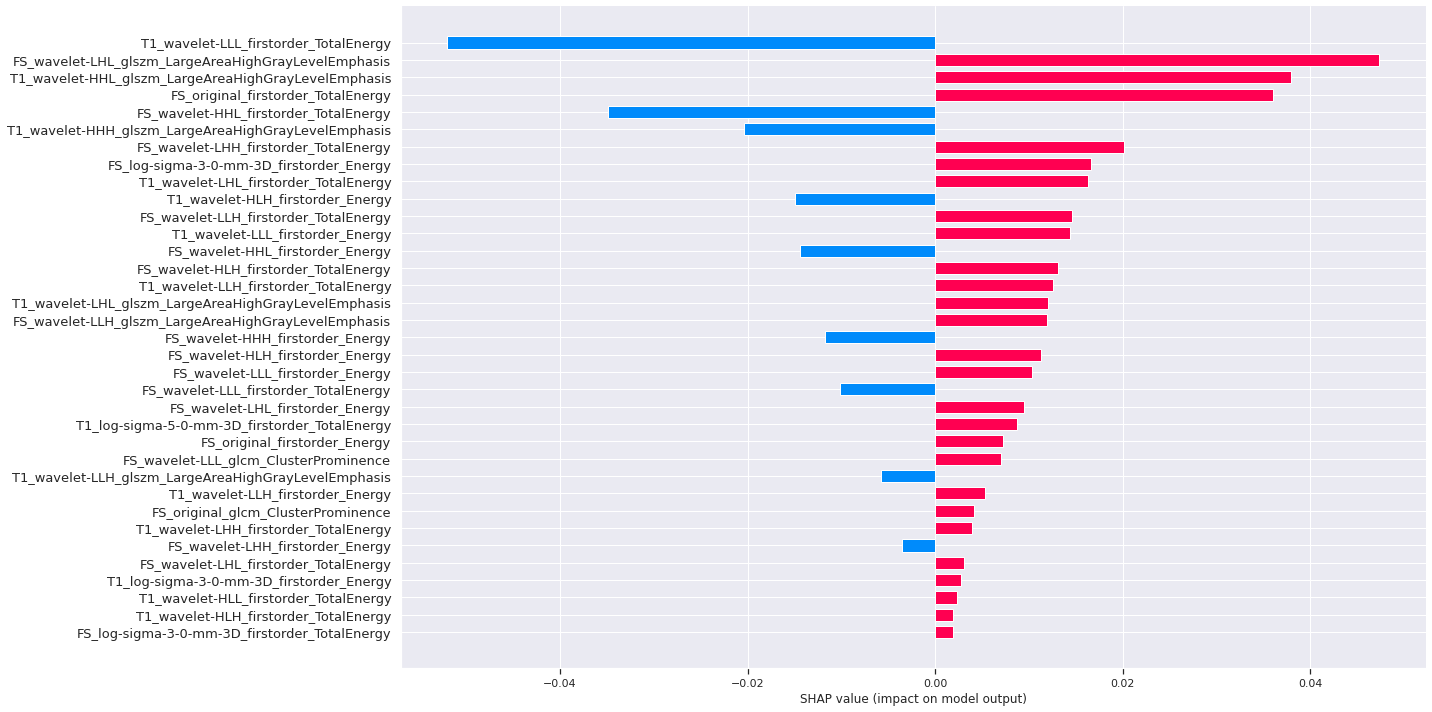

In [ ]:
shap.bar_plot(shap_values[1][7], feature_names=explainer.feature_names, max_display=35, show=False)
plt.gcf().set_size_inches(20, 10)
plt.tight_layout()
